# rare-common network colocalization

generate network colocalization values fo ACN. Note: due to permutation, each run will have slight differences in values
Figures generated:
- Fig 2
- Fig S3

# setup

In [1]:
#read in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2 
import scipy.stats as stats
import matplotlib
from scipy.stats import hypergeom
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import os
import sys
from rca_functions import *
from glob import glob
from mpl_toolkits.mplot3d import Axes3D

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
os.chdir('../')

In [4]:
os.getcwd()

'/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison'

In [5]:
save_file=False
save_fig=False
recalculate_enrichment=False

cutoff_comb=3
cutoff_single=1.5

## Interactome Set-up

In [6]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


In [7]:
interactome_name='pcnet_v14'
UUIDs #imported from rca_functions

{'pcnet_v14': 'c3554b4e-8c81-11ed-a157-005056ae23aa',
 'pcnet_v13': '4de852d9-9908-11e9-bcaf-0ac135e8bacf',
 'string': '98ba6a19-586e-11e7-8f50-0ac135e8bacf',
 'humanNet_v3_FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'ACN': '29b2d215-07fd-11ef-9621-005056ae23aa',
 'ACN_unannot': 'f81a3f67-4215-11ee-aa50-005056ae23aa',
 'ACN_strin': '48de252c-3d50-11ee-aa50-005056ae23aa'}

In [8]:
interactome=import_interactome(interactome_name)
interactome_nodes=list(interactome.nodes())

pcnet_v14
number of nodes:
18630

number of edges:
2687393


# Run analysis for rare and common alcohol consumption traits

loops through the chosen rare and common datasets to calculate the overlapping network, and subsequent statstical secondary analyses

## import metadata for datasets- includes delimiters, column names, file names, etc.

In [9]:
common_datasets=pd.read_csv('common_datasets_prepub.csv',sep=',')
rare_datasets=pd.read_csv('rare_datasets_prepub.csv',sep=',')

In [10]:
common_datasets

,group,snp2gene_method,label,phenotype_group,seed_path,delim,zscore_file,zscore_path,seed_p,seed_gene_name,description,cutoff
0,GSCAN_DPW,magma,GSCAN_DPW_magma,alcohol,input_files/GSCAN_DPW/GSCAN_DPW_magma_results.csv,comma,gscan_dpw_magma_zscore.tsv,calculated_values/network_scores/gscan_dpw_mag...,P,GENE_NAME,drinks_per_week_gscan,bonferroni
1,neale_20153_irnt,magma,neale_20153_irnt_magma,control,input_files/neale_ctrl/20153_magma_output.tsv,NaN,neale_20153_magma_zscore.tsv,calculated_values/network_scores/neale_20153_m...,P,SYMBOL,FEV1,bonferroni
2,neale_4104_irnt,magma,neale_4104_irnt_magma,control,input_files/neale_ctrl/4104_magma_output.tsv,tab,neale_4104_irnt_magma_zscore.tsv,calculated_values/network_scores/neale_4104_ir...,P,SYMBOL,heel_bone_density,bonferroni


In [11]:
rare_datasets

,label,cutoff used,seed_path,delim,zscore_file,zscore_path,seed_gene_name,phenotype_group
0,alcoholintake_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/alcohol_inta...,comma,alcoholintake_fdr_25_zscore.tsv,calculated_values/network_scores/alcoholintake...,Gene Name,alcohol
1,rare_neale_20153_irnt_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/20153_irnt/2...,tab,rare_neale_20153_irnt_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_20...,Gene Name,control
2,rare_neale_20016_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/20016/20016_...,tab,rare_neale_20016_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_20...,Gene Name,control
3,rare_neale_4194_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/4194/4194_25...,tab,rare_neale_4194_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_41...,Gene Name,control
4,rare_neale_78_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/78/78_25FDR.tsv,tab,rare_neale_78_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_78...,Gene Name,control
5,rare_neale_C50_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/C50/C50_25FD...,tab,rare_neale_c50_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_c5...,Gene Name,control
6,rare_neale_C44_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/C44/C44_25FD...,tab,rare_neale_c44_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_c4...,Gene Name,control
7,rare_neale_100016_FDR_25,all tests FDR <0.25,input_files/rare_variant_genebass/100016/10001...,tab,rare_neale_100016_fdr_25_zscore.tsv,calculated_values/network_scores/rare_neale_10...,Gene Name,control
8,rare_strin_allcut_alcoholintake,burden bonferroni < 0.05 in the whole table of...,input_files/rare_variant_genebass/alcohol_inta...,comma,rare_strin_allcut_alcoholintake_zscore.tsv,calculated_values/network_scores/rare_strin_al...,gene_symbol,alcohol


## import zscores and seed genes from datasets of interest

In [12]:
#select row that contains rare and common datasets for our primary dataset (phenotype_group 'alcohol', rare FDR25 cutoff, common bonferroni)
row_rare=rare_datasets[rare_datasets['label']=='alcoholintake_FDR_25'].index[0]#row of rare_datasets that contains metadata for rare variant files
row_common=common_datasets[common_datasets['label']=='GSCAN_DPW_magma'].index[0] #row of common_datasets that contains metadata for rare variant files

In [13]:
label_rare=rare_datasets['label'][row_rare]
print('analyzing rare dataset: '+label_rare)
seed_rare=import_seedgenes(path=rare_datasets['seed_path'][row_rare],
                           pcol=None,
                           gene_col=rare_datasets['seed_gene_name'],
                            delim=rare_datasets['delim'][row_rare])
seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]))
zscore_rare_df=import_nps_zscores(z_path=rare_datasets['zscore_path'][row_rare], interactome_name='pcnet_v14')
label_common=common_datasets['label'][row_common]
print('analyzing common dataset: '+label_common)
seed_common=import_seedgenes(path=common_datasets['seed_path'][row_common],
                            pcol=common_datasets['seed_p'][row_common], 
                            gene_col=common_datasets['seed_gene_name'][row_common],
                            delim=common_datasets['delim'][row_common],
                            cutoff=common_datasets['cutoff'][row_common])
seed_common=list(set(seed_common[common_datasets['seed_gene_name'][row_common]]))
zscore_common_df=import_nps_zscores(z_path=(common_datasets['zscore_path'][row_common]), interactome_name='pcnet_v14')


analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
    Gene Name          Gene Id  P-Value SKATO  P-Value Burden  P-Value SKAT  \
0       MMEL1  ENSG00000142606       0.000037        0.000017      0.002806   
1        MTOR  ENSG00000198793       0.000112        0.000036      0.048810   
2  AC118553.2  ENSG00000283761       0.000138        0.000128      0.000453   
3      KIF21B  ENSG00000116852       0.000063        0.000141      0.000477   
4       KDM5B  ENSG00000117139       0.000043        0.000023      0.010125   

   BETA Burden   Burden Set  Chrom : Position Chrom   Position  burden_FDR  \
0     0.001404  missense|LC      1.002587e+09     1    2586658    0.121878   
1    -0.018638         pLoF      1.011107e+09     1   11106515    0.149029   
2    -0.005127   synonymous      1.099970e+09     1   99970489    0.266147   
3    -0.014921         pLoF      1.200974e+09     1  200973806    0.2730

## Graph rare vs common NPS scores- Fig 2B, Fig2C, Fig S3A

generate histograms of the NPS scores from the rare and common datasets, with and without seed genes, combined NPS scores, and scatter plot of NPS scores

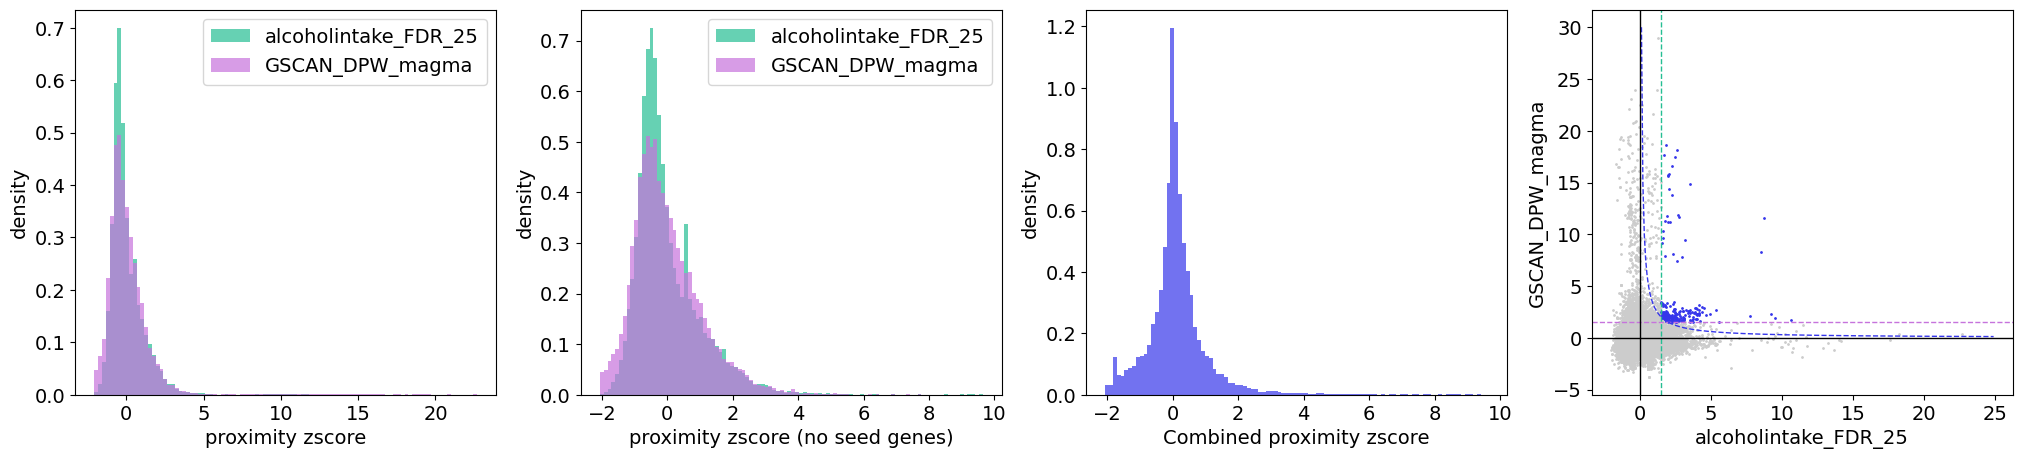

In [14]:
#import rare seed gene list and NPS scores
plt_histogram(zscore_rare_df, zscore_common_df, str(label_rare), str(label_common),seed_rare,seed_common, 1.5, 1.5,3, save_fig)

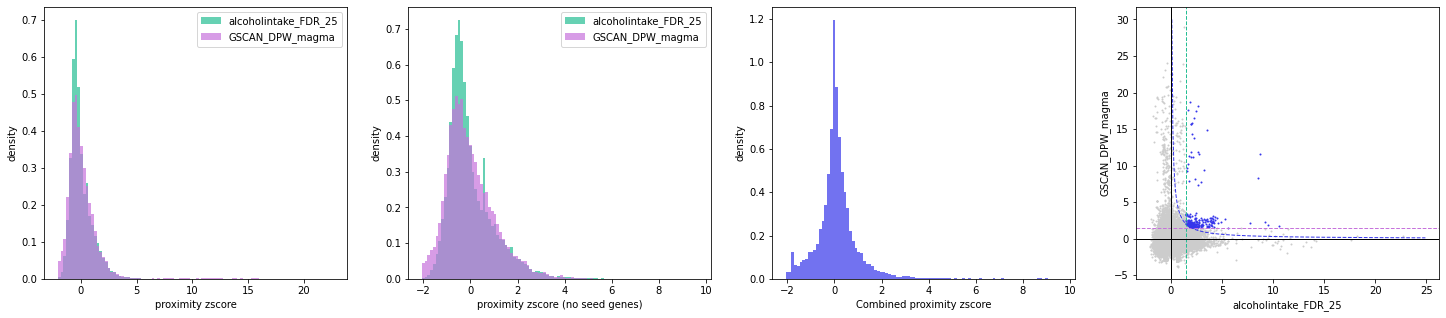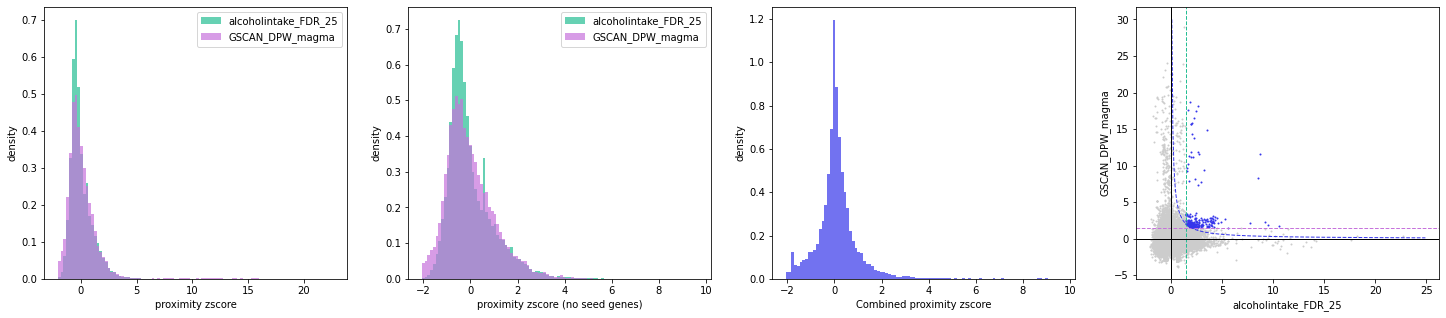## Venn diagram seed genes- Fig 2A (left)

N rare seed genes- alcoholintake_FDR_25: 35
N common seed genes- GSCAN_DPW_magma: 294
{'ADH1B', 'GCKR', 'ADH1C'}
{'ADH1B', 'ADH1C'}


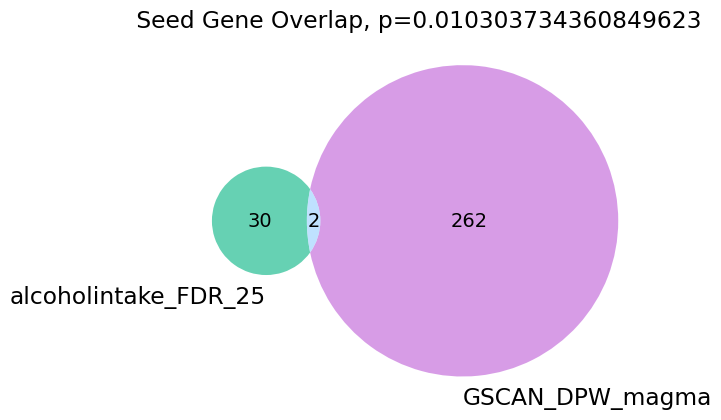

In [15]:
print('N rare seed genes- '+label_rare+': '+str(len(set(seed_rare))))
print('N common seed genes- '+label_common+': '+str(len(set(seed_common))))
print(set(seed_rare).intersection(set(seed_common)))

venn_seeds(seed_rare,seed_common,label_rare, label_common, interactome_nodes, save_fig)        

# calculate network enrichment for ACN

In [16]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,4,5,6,7,8,9,10]
z12list = [1,1.5,2,3,4,5]

In [21]:
netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(zscore_rare_df,zscore_common_df,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=False)
#netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
print(netcoloc_enrichment_df)
netcoloc_enrichment_df['rare_dataset']=label_rare
netcoloc_enrichment_df['common_dataset']=label_common
if save_file:
    netcoloc_enrichment_df.to_csv('calculated_values/colocalization_scores/colocScore_'+label_common+'_'+label_common+UUID_tag[interactome_name]+'.tsv',sep='\t',index=False)

pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cutoff_comb) & (netcoloc_enrichment_df['z_12']==cutoff_single)]['empirical_p'])

    z_comb  z_12  observed_overlap  expected_overlap_mean  \
0        1   1.0               571                 450.82   
1        1   1.5               223                 161.38   
2        1   2.0                79                  58.27   
3        1   3.0                 5                   7.38   
4        1   4.0                 2                   2.27   
5        1   5.0                 2                   0.94   
6        2   1.0               435                 346.97   
7        2   1.5               223                 162.34   
8        2   2.0                79                  57.06   
9        2   3.0                 5                   8.01   
10       2   4.0                 2                   2.31   
11       2   5.0                 2                   1.07   
12       3   1.0               299                 231.80   
13       3   1.5               208                 146.86   
14       3   2.0                79                  56.53   
15       3   3.0        

## network genes venn diagram - Fig2A (right)

1.5
208


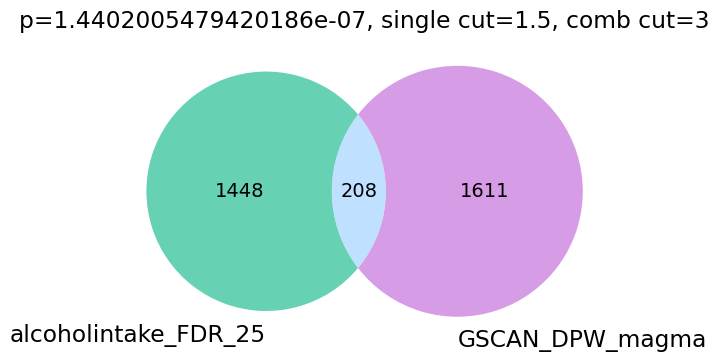

In [23]:
venn_net(zscore_rare_df['z'], zscore_common_df['z'], label_rare, label_common, pOverlap, tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=save_fig)

## histogram observed vs permuted network size

In [ ]:
observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(zscore_common_df.iloc[:,0], zscore_rare_df.iloc[:,0], 
                                                            z_score_threshold=cutoff_comb, z1_threshold=cutoff_single,
                                                            z2_threshold=cutoff_single, num_reps=10000, plot=False)                                                                   
plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted", color=color_dict['other'], arrow_color=color_dict['shared'],savefig=save_fig, filename='networksize_hist.svg')

## histogram observed vs permuted node mean NPScr

In [ ]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(zscore_common_df, zscore_rare_df, num_reps=10000,
                                                        zero_double_negatives=False, overlap_control="bin",
                                                        seed1=list(set(seed_common).intersection(interactome_nodes)), seed2=list(set(seed_rare).intersection(interactome_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted", color=color_dict['other'], arrow_color=color_dict['shared'],savefig=save_fig, filename='mean_NPScr_hist.svg')

## generate the ACN (unannotated)- save to ndexbio

In [ ]:
net=network_colocalization.calculate_network_overlap_subgraph(interactome, zscore_rare_df['z'].squeeze(), zscore_common_df['z'].squeeze(), cutoff_comb, cutoff_single, cutoff_single)
net2=format_network(net, label_rare, label_common, seed_rare , seed_common, zscore_rare_df['z'].squeeze(), zscore_common_df['z'].squeeze())
print(net2.nodes())
if save_file:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_rare+'_'+label_common+'_'+UUID_tag[interactome_name]), user=ndex_user, password=ndex_password)


# plot network enrichment for variable NPS scores- Fig S2

In [ ]:
netcoloc_enrichment_df.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset', 'logp']

In [ ]:
netcoloc_enrichment_df=pd.read_csv('calculated_values/colocalization_scores/colocScore_GSCAN_DPW_magma_alcoholintake_FDR_25.tsv',sep='\t')

In [ ]:
netcoloc_enrichment_df.head()

In [ ]:
NPS_lineplot(netcoloc_enrichment_df,'observed_overlap','network_overlap_ACN.svg',xrange=[0,10.5], yrange=[-10,600],savefig=save_fig)

In [ ]:
NPS_lineplot(netcoloc_enrichment_df,'-log10(p)','network_overlap_pval_ACN.svg',xrange=[0,10.5], yrange=[-0.5,10],savefig=save_fig,sigline=True)

In [ ]:
NPS_lineplot(netcoloc_enrichment_df,'obs_exp','network_overlap_obsexp_ACN.svg',xrange=[0,10.5],yrange=[0.5,2.5],savefig=save_fig)

In [ ]:
temp=netcoloc_enrichment_df[netcoloc_enrichment_df['empirical_p']<0.05/len(netcoloc_enrichment_df)]

NPS_lineplot(temp,'obs_exp','network_overlap_obsexp_sig_ACN.svg',xrange=[0,10.5],yrange=[1.2,1.6],savefig=save_fig)

In [ ]:
NPS_lineplot(temp,'-log10(p)','network_overlap_pval_sig_ACN.svg',xrange=[0,10.5], yrange=[-0.5,10],savefig=save_fig)

In [ ]:
NPS_lineplot(temp,'observed_overlap','network_overlap_sig_ACN.svg',xrange=[0,10.5], yrange=[-10,600],savefig=save_fig)

# calculate and plot network enrichment for control traits

## Table S7

In [ ]:
#build table of comparisons for enrichment analysis
enr=pd.DataFrame()
enr['rare_label']=rare_datasets['label'].squeeze()
enr['common_label']='GSCAN_DPW_magma'
enr.loc[len(enr.index)] = ['rare_neale_20153_irnt_FDR_25','neale_20153_irnt_magma']

temp=pd.DataFrame()
temp['common_label']=common_datasets['label'].squeeze()
temp['rare_label']='alcoholintake_FDR_25'

enr=pd.concat([enr, temp],axis=0)
enr=enr.drop(0, axis=0).reset_index()

In [ ]:
enr_out=pd.DataFrame()
for i in range(len(enr)):
    label_rare=enr['rare_label'][i]
    label_common=enr['common_label'][i]
    r=rare_datasets[rare_datasets['label']==label_rare].index[0]
    c=common_datasets[common_datasets['label']==label_common].index[0]
    seed_rare=import_seedgenes(path=rare_datasets['seed_path'][r],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'][r],
                                delim=rare_datasets['delim'][r])
    
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][r]]))
    zscore_rare_df=import_nps_zscores(z_path=rare_datasets['zscore_path'][r], interactome_name='pcnet_v14')
    
    seed_common=import_seedgenes(path=common_datasets['seed_path'][c],
                                    pcol=common_datasets['seed_p'][c], 
                                    gene_col=common_datasets['seed_gene_name'][c],
                                    delim=common_datasets['delim'][c],
                                    cutoff=common_datasets['cutoff'][c])
    seed_common=list(set(seed_common[common_datasets['seed_gene_name'][c]]))    
    zscore_common_df=import_nps_zscores(z_path=common_datasets['zscore_path'][c], interactome_name='pcnet_v14')

    t = network_colocalization.calculate_network_enrichment(zscore_rare_df,zscore_common_df,
                                                                             zthresh_list = [3],
                                                                             z12thresh_list=[1.5],
                                                                             verbose=False)
    t['rare_dataset']=label_rare
    t['common_dataset']=label_common
    enr_out=pd.concat([enr_out,t], axis=0)
enr_out.loc[-1]=netcoloc_enrichment_df.loc[13] #fixed based on the current set of NPS scores being run- need to manually change if adjust those thresholds
enr_out=enr_out.reset_index().drop('index', axis=1)
enr_out.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset']
enr_out.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset']
enr_out['logp']=-np.log10(enr_out['empirical_p'])
#add alcohol enrichment calculated above
i=netcoloc_enrichment_df[(netcoloc_enrichment_df['NPS_single']==1.5) & (netcoloc_enrichment_df['NPS_common-rare']==3)].index[0]
enr_out.loc[len(enr_out.index)] = netcoloc_enrichment_df.iloc[i]
enr_out['sig']=enr_out['empirical_p']<0.05/len(enr_out)
enr_out['lower_error'] = enr_out.apply(lambda x: x['obs_exp'] - x['observed_overlap']/(x['expected_overlap_mean']+ 1.96*x['expected_overlap_std']), axis = 1)
enr_out['upper_error'] = enr_out.apply(lambda x: x['observed_overlap']/(x['expected_overlap_mean'] - 1.96*x['expected_overlap_std']) - x['obs_exp'], axis = 1)
if save_file:
    enr_out.to_csv('calculated_values/colocalization_scores/colocalization_scores_resubmission.tsv',sep='\t')

## Fig S3C

In [ ]:
temp=enr_out[((enr_out['rare_dataset']=='rare_neale_20153_irnt_FDR_25')|(enr_out['rare_dataset']=='rare_strin_allcut_alcoholintake')|(enr_out['rare_dataset']=='alcoholintake_FDR_25'))&
((enr_out['common_dataset']=='GSCAN_DPW_magma')|(enr_out['common_dataset']=='neale_20153_irnt_magma'))].sort_values(by='rare_dataset', ascending=True)
temp.index=[1,0,2,3,4]
temp=temp.sort_index(axis=0, ascending=True)
temp['lower_error'] = temp.apply(lambda x: x.obs_exp - x.observed_overlap/(x.expected_overlap_mean + 1.96*x.expected_overlap_std), axis = 1)
temp['upper_error'] = temp.apply(lambda x: x.observed_overlap/(x.expected_overlap_mean - 1.96*x.expected_overlap_std) - x.obs_exp, axis = 1)

In [ ]:
temp

In [ ]:
plt.figure(figsize=(5,4))
plt.bar(x = temp.rare_dataset+' | '+temp.common_dataset,
       bottom= 1, height = temp.obs_exp-1, capsize=4, edgecolor="black",
        yerr = [temp.lower_error, temp.upper_error],
        color =[color_dict['shared'],'white',color_dict['other'],'grey',color_dict['shared']])
plt.xticks(rotation = 90)
plt.ylabel('obs/exp network overlap')
plt.axhline(y = 1, color = 'black', linestyle = 'solid', linewidth=1)
if save_fig:
    plt.savefig('figures/barplot_network_overlap_sfig.svg',bbox_inches='tight')

## Fig 2D

In [ ]:
temp=temp.drop([3,4],axis=0)

In [ ]:
plt.figure(figsize=(3,4))
plt.bar(x = temp.rare_dataset+' | '+temp.common_dataset,
       bottom= 1, height = temp.obs_exp-1, capsize=4, edgecolor="black",
        yerr = [temp.lower_error, temp.upper_error],
        color =[color_dict['shared'],'white',color_dict['other'],'grey',color_dict['shared']])
plt.xticks(rotation = 90)
plt.ylabel('obs/exp network overlap')
plt.axhline(y = 1, color = 'black', linestyle = 'solid', linewidth=1)
if save_fig:
    plt.savefig('figures/barplot_network_overlap_mainfig.svg',bbox_inches='tight')